In [1]:
import pandas as pd
import pm4py

### Importing the log

In [ ]:
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter
file_path = "./Road_Traffic_Fine_Management_Process.xes"
xes_event_log = xes_importer.apply(file_path)

event_log = converter.apply(xes_event_log, variant=converter.Variants.TO_DATA_FRAME)

event_log

In [ ]:
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

### Process Discovery
Petri Net (using two different algorithms)

c:\users\diego\desktop\pm4py-test\venv\lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:82: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_reduced = df[{case_id_glue, activity_key, target_activity_key}]


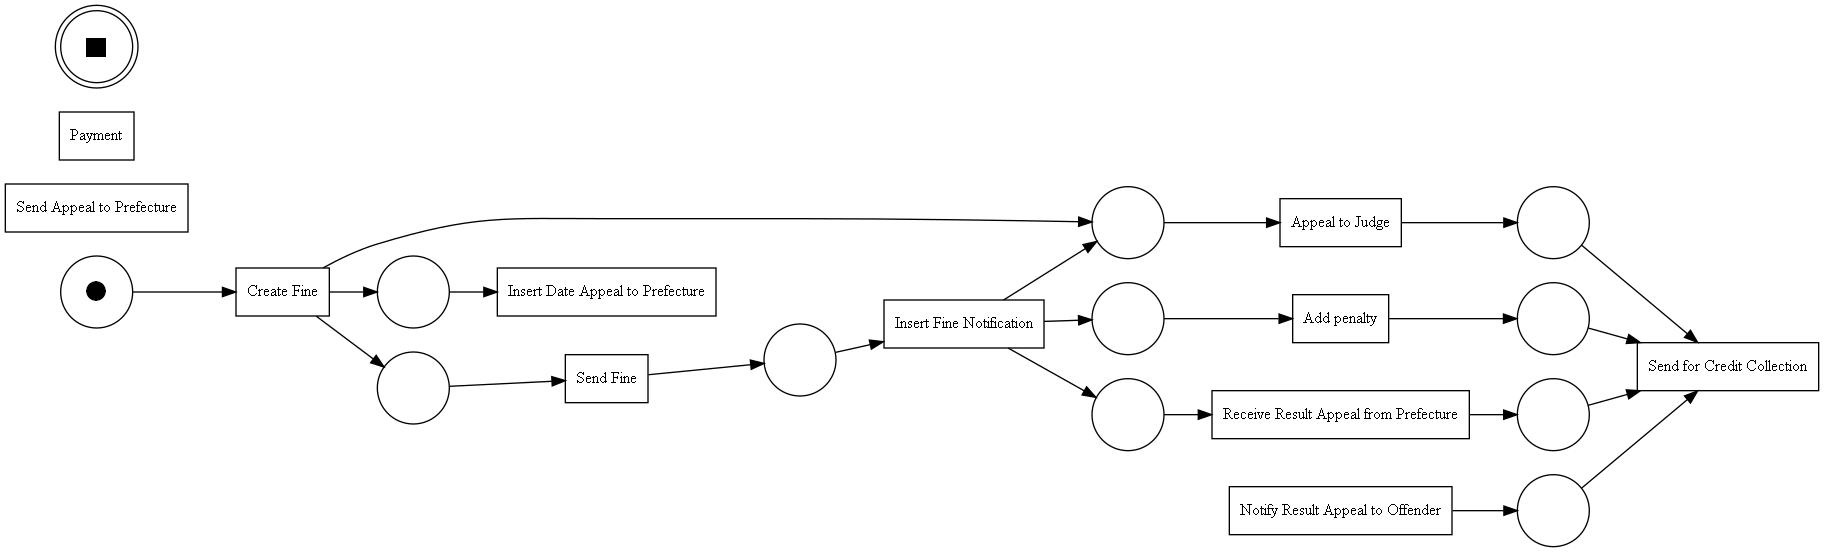

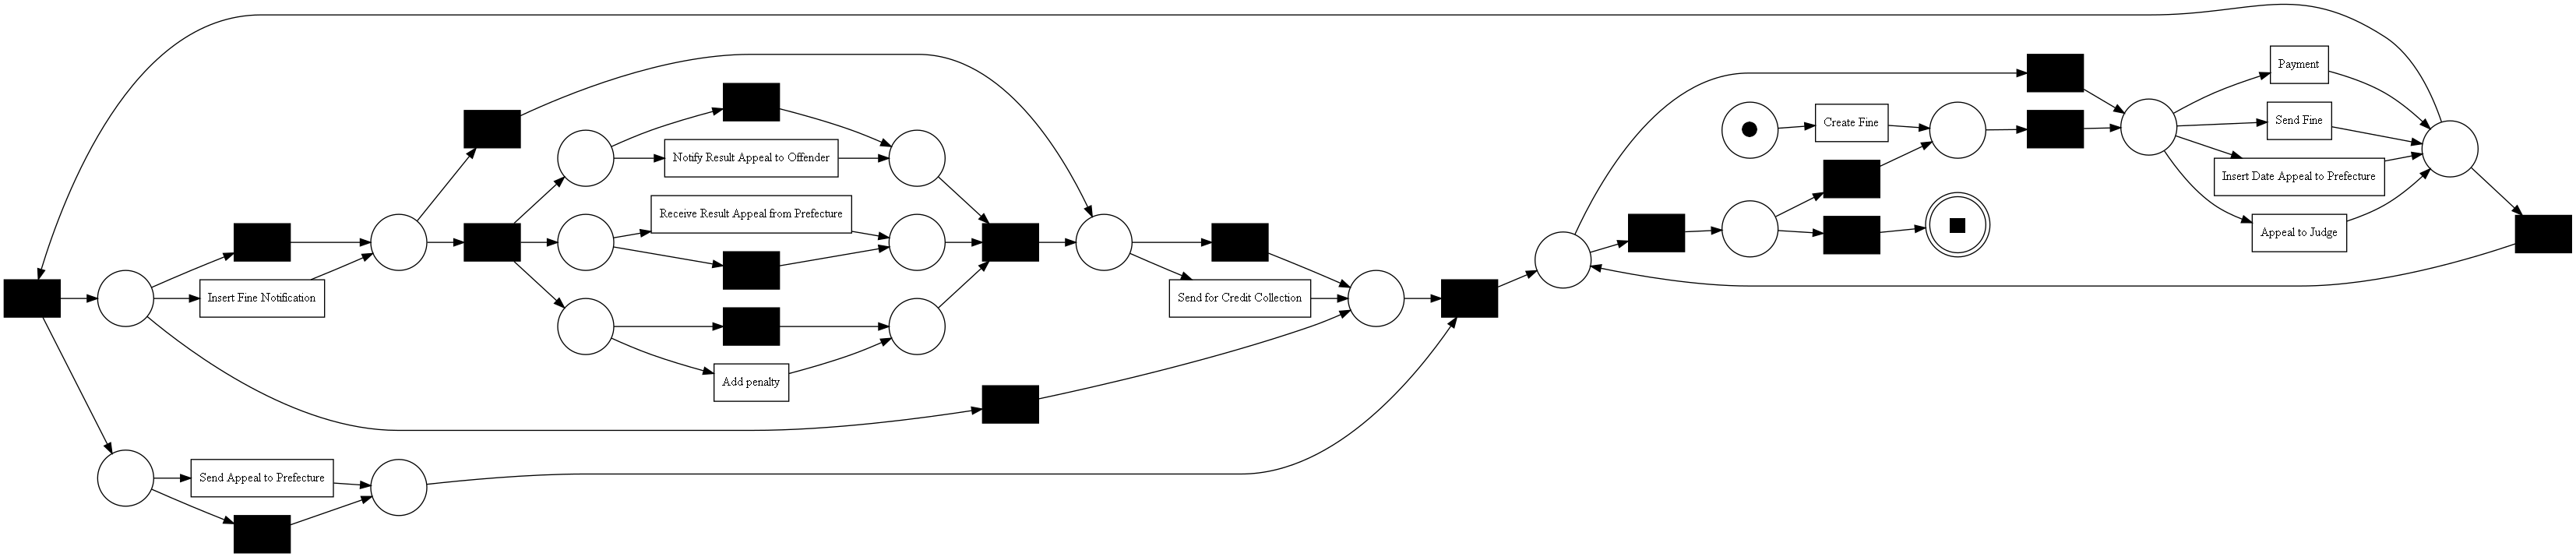

In [4]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# Alpha Miner
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
alpha_net, alpha_initial_marking, alpha_final_marking = alpha_miner.apply(event_log)
alpha_graphviz = pn_visualizer.apply(alpha_net, alpha_initial_marking, alpha_final_marking)
alpha_graphviz.graph_attr['bgcolor'] = 'white'
pn_visualizer.view(alpha_graphviz)
# pn_visualizer.save(alpha_graphviz, "pn_alpha_miner.png")

# Inductive Miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
ind_net, ind_initial_marking, ind_final_marking = inductive_miner.apply(event_log)
ind_graphviz = pn_visualizer.apply(ind_net, ind_initial_marking, ind_final_marking)
ind_graphviz.graph_attr['bgcolor'] = 'white'
pn_visualizer.view(ind_graphviz)
# pn_visualizer.save(ind_graphviz, "pn_inductive_miner.png")

Other possible process models

In [ ]:
# Process Tree
process_tree = pm4py.discover_process_tree_inductive(event_log)
pm4py.view_process_tree(process_tree)

# BPMN Model
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model)

# Process Map (Directly Follows Graph)
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

# Heuristic Miner
heu = pm4py.discover_heuristics_net(event_log)
pm4py.view_heuristics_net(heu)

### Decision points

In [5]:
# For each decision point (place with at least 2 outgoing arcs), gets the labels of the target transitions
# Invisible transitions (in case of the inductive miner) are not taken into account for now: decision nodes with invisible transitions are simply not considered in the analysis

decision_points_trans = dict()

def find_decision_point_transitions(decision_point):
    for arc in decision_point.out_arcs:
        if arc.target.label is not None:
            decision_points_trans[decision_point].append(arc.target.label)
        #else:
            #trans_out = arc.target
            #trans_out_arcs = trans_out.out_arcs
            #for arc2 in trans_out_arcs:
                #find_decision_points(arc2.target)

    # Removing nodes with following invisible transitions (= only one transition in the dictionary)
    if len(decision_points_trans[decision_point]) < 2:
        del decision_points_trans[decision_point]

for place in ind_net.places:
    if len(place.out_arcs) >= 2:
        decision_points_trans[place] = list()
        find_decision_point_transitions(place)

decision_points_trans

{p_7: ['Appeal to Judge',
  'Send Fine',
  'Insert Date Appeal to Prefecture',
  'Payment']}

### Observation instances
Now that for every decision point we have the list of observed transitions, we need to build the observation instances.
The observation instances of a decision point are the instances (x, t) where x are the observed values of the attributes, while t is the observed transition.
So, every time we see a transition t in the event log, we retrieve the values x of the attributes before the transition happens, and we add the instance to the observation instances for that decision point.

In [ ]:
import math
amount = dict()
gb = event_log.groupby(['case:concept:name'])

# ONLY 1 DECISION POINT FOR NOW, NEEDS TO BE GENERALIZED (MULTI-DIMENSIONAL MATRIX?)
for dp in decision_points_trans:
    for trans in decision_points_trans[dp]:
        amount[trans] = list()
        # For each transition, I put in this list the values of the attributes observed before that transition happened (TESTING ONLY WITH ATTRIBUTE "AMOUNT" FOR NOW)
        # Need to look in the event_log dataframe and handle NaN/NIL values, going back within the same case
        for case in gb.groups:
            for row in gb.groups[case]:
                if event_log.iloc[row]['concept:name'] == trans:
                    row_iter = row
                    # If nan, go back within the same case to find the value (if any) until going back would be too much (beginning of that case)
                    while row_iter >= gb.groups[case][0]:
                        if not math.isnan(event_log.iloc[row_iter]['amount']):
                            amount[trans].append(event_log.iloc[row_iter]['amount'])
                            break
                        row_iter = row_iter - 1


amount